<a href="https://colab.research.google.com/github/Fondzenyuy/AST326Y1/blob/main/ast325_tutorial_2_solutions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST 325 Tutorial #2 - All things Poisson!

## 0. Setup

Just so we are all on the same page, let's import Numpy and Matplotlib (and setup Jupyter to show plots inline).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## 1. Warm-up exercise: Poisson or Not?

This warm-up exercise is about the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Can you tell when some data is Poissonian or not?

You are given 3 datasets of 2500 numbers each.

In [3]:
import urllib.request

file = urllib.request.urlopen("https://www.astro.utoronto.ca/~mahajan/ast325/warm-up.txt")
data1, data2, data3 = np.loadtxt(file, dtype=int)

**Analyze them to figure out which ones were sampled from a Poisson distribution, and which ones were not.**

### Solution

Remember, for a Poisson distribution the mean is equal to the variance, and for large means it should look a lot like the normal distribution.  
Let's print the means and variances of the datasets and plot their histograms!

In [4]:
for i, data in enumerate([data1, data2, data3], 1):
    print(f"Dataset {i}: Mean = {data.mean():7.2f}, Variance = {data.var():7.2f}")

Dataset 1: Mean =  999.38, Variance =  951.89
Dataset 2: Mean = 1000.85, Variance =  952.42
Dataset 3: Mean =  999.82, Variance =  473.67


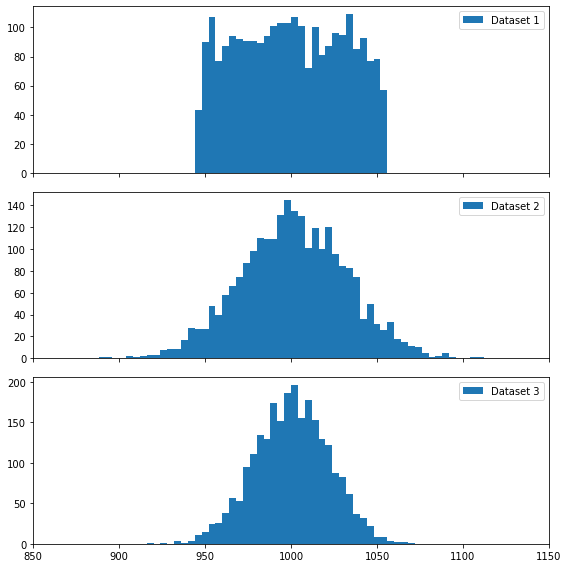

In [5]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8), tight_layout=True)

hist_kw = dict(bins=100, range=(800, 1200))
for i, data in enumerate([data1, data2, data3]):
    axes[i].hist(data, label=f"Dataset {i+1}", **hist_kw)
    axes[i].legend()
axes[-1].set_xlim(850, 1150)
plt.show()

Dataset 1: Clearly not Poisson (from the shape of the histogram, it's a uniform distribution).  
Dataset 2: Has the expected bell curve shape and mean is similar to variance. This is Poisson.  
Dataset 3 Also, not poisson because the variance is not the same as the mean!

## 2. Alice and Bob find a laser

Alice and Bob find a laser on their adventures. Unfortunately, the part of the label that specifies the wavelength of the laser has rubbed off. Alice and Bob want to figure out the wavelength of the laser so they can write it back onto the label - because safety comes first, you know?

Coincidentally, Alice has a device that she can use to measure the irradiance of the laser (say, a bolometer). She uses this bolometer to measure the total energy emitted by the laser over a short fixed time interval and she repeats this measurement a thousand times (under identical conditions).

Unfortunately, they skipped their statistics lecture to go on this adventure - so they need your help! You are given a dataset containing 1000 numbers: measurements of total photon energy from the laser in units of *electronvolts (eV)*.

**Given, these measurements, can you help them figure out what the wavelength of the laser is?**

In [6]:
import astropy.units as u
import astropy.constants

file = urllib.request.urlopen("https://www.astro.utoronto.ca/~mahajan/ast325/alice_and_bob_laser.txt")
data = np.loadtxt(file, dtype=float)

# You'll need these constants
h = astropy.constants.h  # Planck's Constant
c = astropy.constants.c  # Speed of Light

Bob has some helpful tips for you:
1. The laser is a monochromatic source - all photons have the same frequency.
2. The laser has constant brightness.
3. The energy of a single photon is $E = \frac{hc}{\lambda}$.

### Solution

Remember that we are really just counting photons here - so poisson statistics apply. So, if we detect $N$ photons on average, the standard deviation on the number of photons should be $\sqrt{N}$. Let's write this in terms of total energy measured by Alice:

$$ \langle E \rangle = \frac{N h c}{\lambda} $$

$$ \sigma_E = \frac{\sqrt{N} h c}{\lambda} $$

So, we can estimate the wavelength with

$$ \lambda = \frac{h c \langle E \rangle}{{\sigma_E}^2} $$

In [7]:
# First apply the units
data = data * u.eV

mean_energy = data.mean()
std_dev_energy = data.std()

print(f"Mean Total Energy: {mean_energy}")
print(f"Standard Deviation: {std_dev_energy}")

Mean Total Energy: 77.91614999999999 eV
Standard Deviation: 2.978092153963675 eV


In [8]:
wavelength = h * c * mean_energy / std_dev_energy**2

# Convert to micrometers
wavelength = wavelength.to(u.um)

print(f"Wavelength: {wavelength}")

Wavelength: 10.89224894775005 um


#### Optional: Uncertainty on wavelength

Propagation of uncertainty is hard and unless you know exactly what you are doing, you can easily under-estimate or over-estimate your errors. This is because the simple rules for "propagation of uncertainty" that you probably learned in class only work in very specific, wonderfully beautiful, almost perfect conditions. The only time you have these conditions are in ... well, problem sets!

For example, if I give you a sample of $20$ values (say, heights of students) and asked you to compute the "median" height - you probably can. But can you find the "error" on that median? The median is a non-linear, non-differentiable function.

But do you know how to find the uncertainty over the "median" of a dataset? (Do you even know how to take the derivative of the median function relative to your individual samples? Don't bother, you'll go crazy)

Thankfully, there's an excellent and simple technique to determine the errors on pretty much anything: [Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

---

**Situation:** You have a dataset of $N$ samples. You can estimate some quantity as a function of the dataset you are given (for example, the median). But you want to know the error or confidence interval on this quantity.

Use bootstrapping!

1. Put all your data in a bag and randomly pick $N$ samples *with replacement*.

2. Compute your quantity.

3. Do this a bunch of times! You now have a "distribution" on this quantity. Do all the statistics you want to do now.

Let's do this with the wavelength.

In [9]:
def wavelength(data):
    return (h * c * data.mean(-1) / data.var(-1)).to(u.um)

num_bootstrap = 1000
bootstrapped_data = np.random.choice(data.to_value(u.eV), (num_bootstrap, len(data))) * u.eV
bootstrapped_wavelength = wavelength(bootstrapped_data)
bootstrapped_wavelength

<Quantity [11.11935555, 10.63937206, 10.95267139, 10.82878278, 10.07818456,
           11.08009503, 10.28485568, 11.21096725, 10.88930265, 10.99837222,
           11.15884314, 11.40594882, 10.63482162, 10.77760726, 11.03967819,
           12.06722429, 10.84136547, 10.58004562, 10.50345058, 10.84904104,
           10.84479523, 10.47230506, 10.85277585, 10.59208127, 10.5270439 ,
           10.47512519, 10.22916647, 11.63730729, 10.40885941, 11.05996602,
           12.15199104, 10.52692303, 10.94242816, 11.25298533, 10.87602608,
            9.98286217, 11.13514132, 11.62545452, 10.83752569, 10.81115456,
           11.24684305, 10.59404398, 11.5092438 , 11.40861343, 11.79679543,
           11.2617491 , 10.71979605, 10.38323529, 10.17284237, 10.78429657,
           12.16150859, 10.66697125, 10.59543932, 10.42210518, 11.03563136,
           11.12176256, 11.05409119, 10.69697698, 10.56480413, 10.72178662,
           11.04138073, 10.91362211, 10.37987289, 11.25276249, 10.62312724,
           1

In [10]:
m = bootstrapped_wavelength.mean()
err = bootstrapped_wavelength.std()

print(f"Estimated Wavelength: {m:.1f} +/- {err:.1f}")

Estimated Wavelength: 10.9 um +/- 0.5 um


## 3. Wind-down: Q & A

At this point, we probably don't have much time left. **So, let's just have a general Q&A session to end the tutorial.**

Those of you who like statistics might enjoy this bonus problem.

### Bonus Problem: [Poisson Clumping](https://en.wikipedia.org/wiki/Poisson_clumping)

What does random sampling look like? Here are two datasets each containing 1000 points sampled on the unit square from $(0, 0)$ to $(1, 1)$.

In [11]:
file = urllib.request.urlopen("https://www.astro.utoronto.ca/~mahajan/ast325/bonus_random.txt")

x1, y1, x2, y2 = np.loadtxt(file, unpack=True)

`x1` and `y1` are the $(x, y)$ coordinates for points in the first dataset, and similarly for `x2` and `y2`.

Let's plot them.

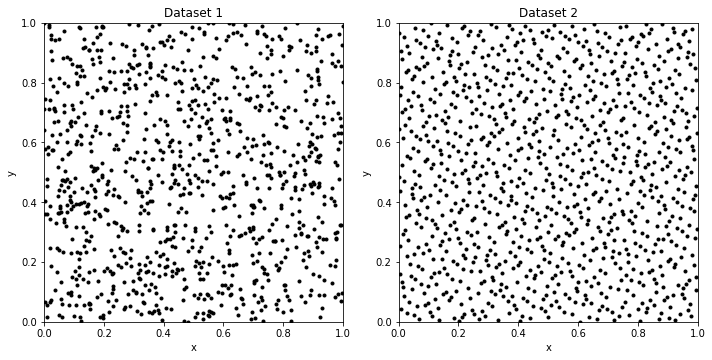

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

for i, (ax, (x, y)) in enumerate(zip(axes, [(x1, y1), (x2, y2)]), 1):
    ax.plot(x, y, 'k.')
    ax.set_aspect(1.0)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i}")

plt.show()

One of these datasets is uniformly sampled and the other is not. Can you tell which is which?  
*Hint: Use your knowledge of Poisson statistics to analyze the data.*

### Solution

We know there are 1000 points over an area of 1. If we assume uniform sampling, we can expect this density to hold as an average.
One simple thing we can do is divide the area into 100 small squares (10 slices along each dimension) and count all the points in each small square - we expect an average of 10 points per square.

The distribution of the number of points in the small squares should follow a poisson distribution with a mean of 10 if the sampling was truly uniform.

I am just going to randomly pick points and count all the samples in a `0.1 x 0.1` area around it (you have to be careful not to go too close to the edge or your square will go outside the larger area). This way I can get way more than 100 measurements because I don't care if the small squares overlap.

In [13]:
def get_counts(x, y, num_squares, square_size):
    counts = np.zeros(num_squares, dtype=int)
    
    s = square_size / 2
    for i in range(num_squares):
        x0, y0 = np.random.uniform(s, 1 - s, 2)  # Can't sample too close to the edge
        points_in_square = (np.abs(x - x0) < s) & (np.abs(y - y0) < s)
        counts[i] = np.sum(points_in_square)
        
    return counts

In [14]:
counts_1 = get_counts(x1, y1, num_squares=10000, square_size=0.1)
counts_2 = get_counts(x2, y2, num_squares=10000, square_size=0.1)

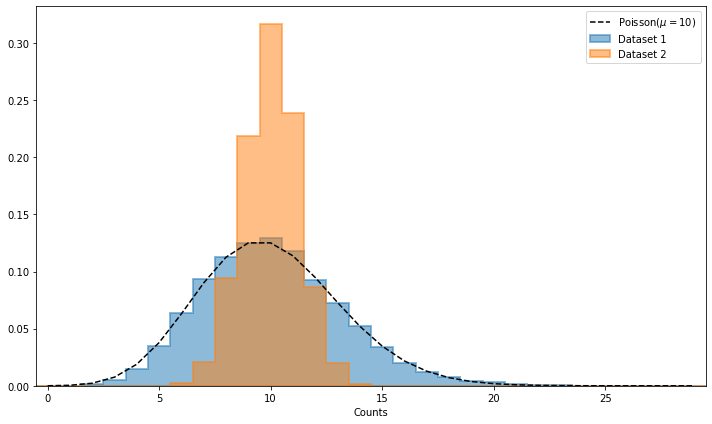

In [15]:
import scipy.stats

k = np.arange(30)
poisson = scipy.stats.poisson.pmf(k, 10)

plt.figure(figsize=(10, 6), tight_layout=True)

hist_kw = dict(range=(-0.5, 29.5), bins=30, density=True, alpha=0.5, histtype='stepfilled', lw=2)
plt.hist(counts_1, label='Dataset 1', edgecolor="C0", **hist_kw)
plt.hist(counts_2, label='Dataset 2', edgecolor="C1", **hist_kw)
plt.plot(k, poisson, 'k--', label=r'Poisson$(\mu=10)$')
plt.xlabel("Counts")
plt.xlim(-0.5, 29.5)
plt.legend()
plt.show()

Dataset 1 is uniformly sampled. Dataset 2 isn't. The randomness is why Dataset 1 exhibits [poisson clumping](https://en.wikipedia.org/wiki/Poisson_clumping). In Dataset 2, notice how all the samples never "clump" together - you couldn't have this property without some clever non-random placement.